## Logistic Regression

Shape of training data: (1241103, 18)
Shape of testing data: (611291, 18)
Shape of training data:  ((1241103, 16), (1241103,))
Shape of testing data:  ((611291, 16), (611291,))

Features used for training (in X_train):
['category', 'amt', 'zip', 'job', 'trans_hour', 'is_night', 'trans_date_trans_time_numeric', 'cust_age', 'cust_age_groups', 'merchant_num', 'last_num', 'street_num', 'city_num', 'zip_num', 'state_num', 'gender_M']

All features in DataFrame after preprocessing:
['category', 'amt', 'zip', 'job', 'trans_num', 'is_fraud', 'trans_hour', 'is_night', 'trans_date_trans_time_numeric', 'cust_age', 'cust_age_groups', 'merchant_num', 'last_num', 'street_num', 'city_num', 'zip_num', 'state_num', 'gender_M']

Feature Coefficients from Logistic Regression:
                          Feature  Coefficient
5                        is_night     1.314474
9                    merchant_num     0.580099
0                        category     0.567335
4                      trans_hour     0.4269

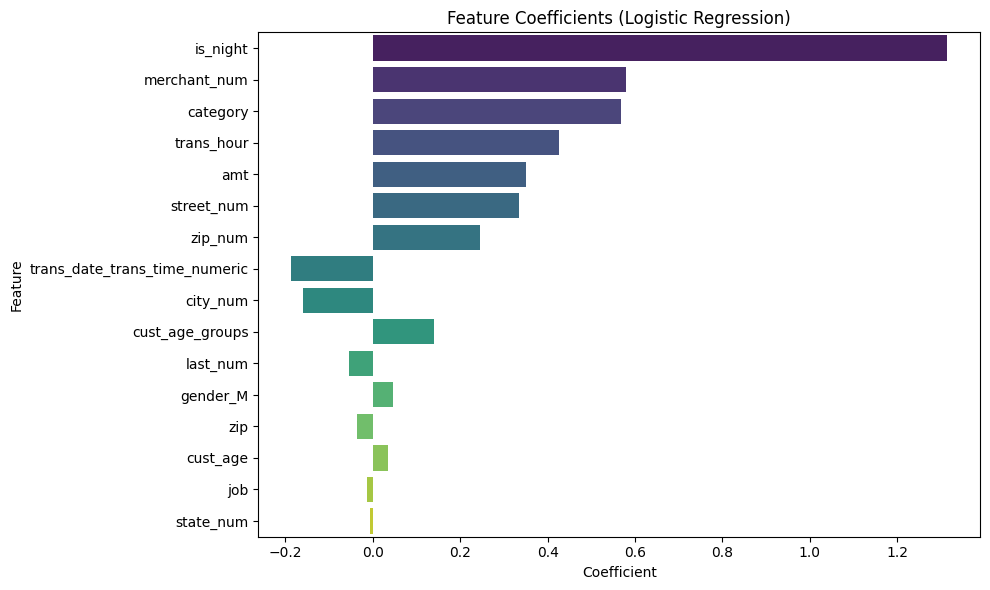


--- Logistic Regression Train Set Evaluation ---
     Threshold  Accuracy  precision_score  recall_score  F1_score
0.1        0.1  0.994863         0.509795      0.362202  0.423508
0.2        0.2  0.995413         0.649516      0.259666  0.371009
0.3        0.3  0.995212         0.648190      0.177235  0.278358
0.4        0.4  0.994930         0.572742      0.105939  0.178804
0.5        0.5  0.994729         0.450904      0.053975  0.096409
0.6        0.6  0.994594         0.248971      0.018713  0.034810
0.7        0.7  0.994560         0.079412      0.004176  0.007934
0.8        0.8  0.994583         0.022305      0.000928  0.001782
0.9        0.9  0.994622         0.000000      0.000000  0.000000
Logistic Regression Train - Best Threshold: 0.1000
Logistic Regression Train - Best ROC_AUC Score: 0.9106

--- Logistic Regression Test Set Evaluation ---
     Threshold  Accuracy  precision_score  recall_score  F1_score
0.1        0.1  0.994800         0.501303      0.362323  0.420631
0.2

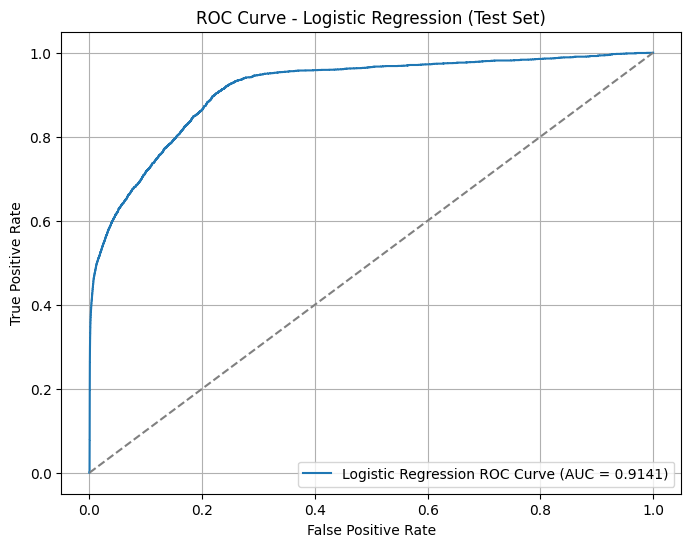

In [4]:
# importing necessary libraries for data loading and EDA
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression  # Import Logistic Regression

warnings.filterwarnings('ignore')

# Loading the data
file_path = '/home/ducanh/Credit Card Transactions Fraud Detection/Datasets/combined_data.csv'
df = pd.read_csv(file_path)

# ------------------ Data Preprocessing ------------------
# Convert time and create time-related features
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['trans_date_trans_time_numeric'] = df['trans_date_trans_time'].apply(lambda x: x.timestamp())
df['trans_hour'] = df['trans_date_trans_time'].dt.time.apply(lambda x: str(x)[:2])

# Process date of birth and compute customer age
df['dob'] = pd.to_datetime(df['dob'])
df['cust_age'] = df['dob'].dt.year.apply(lambda x: 2021 - x)
df['cust_age_groups'] = df['cust_age'].apply(lambda x: 'below 10' if x < 10 else (
    '10-20' if x >= 10 and x < 20 else (
    '20-30' if x >= 20 and x < 30 else (
    '30-40' if x >= 30 and x < 40 else (
    '40-50' if x >= 40 and x < 50 else (
    '50-60' if x >= 50 and x < 60 else (
    '60-70' if x >= 60 and x < 70 else (
    '70-80' if x >= 70 and x < 80 else 'Above 80'))))))))

# Mapping age groups based on average amount in fraudulent transactions
age_piv_2 = pd.pivot_table(data=df,
                           index='cust_age_groups',
                           columns='is_fraud',
                           values='amt',
                           aggfunc=np.mean)
age_piv_2.sort_values(by=1, ascending=True, inplace=True)
age_dic = {k: v for (k, v) in zip(age_piv_2.index.values, age_piv_2.reset_index().index.values)}
df['cust_age_groups'] = df['cust_age_groups'].map(age_dic)

# Encode categorical features and job based on average fraud transaction amount
merch_cat = df[df['is_fraud'] == 1].groupby('category')['amt'].mean().sort_values(ascending=True)
merch_cat_dic = {k: v for (k, v) in zip(merch_cat.index.values, merch_cat.reset_index().index.values)}
df['category'] = df['category'].map(merch_cat_dic)

job_txn_piv_2 = pd.pivot_table(data=df,
                               index='job',
                               columns='is_fraud',
                               values='amt',
                               aggfunc=np.mean)
job_cat_dic = {k: v for (k, v) in zip(job_txn_piv_2.index.values, job_txn_piv_2.reset_index().index.values)}
df['job'] = df['job'].map(job_cat_dic)

# Encode identifier variables using factorize
df['merchant_num'] = pd.factorize(df['merchant'])[0]
df['last_num'] = pd.factorize(df['last'])[0]
df['street_num'] = pd.factorize(df['street'])[0]
df['city_num'] = pd.factorize(df['city'])[0]
df['zip_num'] = pd.factorize(df['zip'])[0]
df['state_num'] = pd.factorize(df['state'])[0]
df = pd.get_dummies(data=df, columns=['gender'], drop_first=True, dtype='int')

# Drop unnecessary columns
drop_cols = ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'first', 'last', 'street', 'city', 'state', 
             'lat', 'long', 'dob', 'unix_time', 'merch_lat', 'merch_long', 'city_pop']
df.drop(columns=drop_cols, errors='ignore', inplace=True)

# ------------------ Train-test Split ------------------
train, test = train_test_split(df, test_size=0.33, random_state=42, stratify=df['is_fraud'])
print("Shape of training data:", train.shape)
print("Shape of testing data:", test.shape)

# Drop 'trans_num' column if exists
train.drop('trans_num', axis=1, inplace=True, errors='ignore')
test.drop('trans_num', axis=1, inplace=True, errors='ignore')

# Separate features and labels
y_train = train['is_fraud']
X_train = train.drop('is_fraud', axis=1)

y_test = test['is_fraud']
X_test = test.drop('is_fraud', axis=1)

print('Shape of training data: ', (X_train.shape, y_train.shape))
print('Shape of testing data: ', (X_test.shape, y_test.shape))

# --- Display features in use ---
print("\nFeatures used for training (in X_train):")
print(X_train.columns.tolist())

print("\nAll features in DataFrame after preprocessing:")
print(df.columns.tolist())

# ------------------ Scaling ------------------
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

X_train_sc = pd.DataFrame(data=X_train_sc, columns=X_train.columns)
X_test_sc = pd.DataFrame(data=X_test_sc, columns=X_test.columns)

# ------------------ Train Logistic Regression ------------------
lr_model = LogisticRegression(random_state=42, max_iter=1000)  # Increased max_iter for convergence
lr_model.fit(X_train_sc, y_train)

# Predict probabilities for training and testing sets
y_pred_train_proba_lr = lr_model.predict_proba(X_train_sc)
y_pred_test_proba_lr = lr_model.predict_proba(X_test_sc)

# Save prediction probabilities into DataFrames
y_train_results_lr = pd.DataFrame(y_pred_train_proba_lr, columns=['pred_not_fraud', 'pred_fraud'])
y_test_results_lr = pd.DataFrame(y_pred_test_proba_lr, columns=['pred_not_fraud', 'pred_fraud'])
y_train_results_lr['y_train_actual'] = y_train.values
y_test_results_lr['y_test_actual'] = y_test.values

# ------------------ Feature Importance ------------------
# Logistic Regression coefficients can serve as feature importance indicators
coefficients = lr_model.coef_[0]
feature_names = X_train_sc.columns
feature_importance_lr = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance_lr['abs_coefficient'] = feature_importance_lr['Coefficient'].abs()
feature_importance_lr.sort_values(by='abs_coefficient', ascending=False, inplace=True)

print("\nFeature Coefficients from Logistic Regression:")
print(feature_importance_lr[['Feature', 'Coefficient']])

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance_lr, palette='viridis')
plt.title('Feature Coefficients (Logistic Regression)')
plt.tight_layout()
plt.show()

# ------------------ Evaluation on Train Set ------------------
numbers = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
cutoff_train_df_lr = pd.DataFrame(columns=['Threshold', 'Accuracy', 'precision_score', 'recall_score', 'F1_score'])

for thresh in numbers:
    # Binary predictions using threshold
    y_pred_bin = y_train_results_lr['pred_fraud'].map(lambda x: 1 if x > thresh else 0)
    cm = confusion_matrix(y_train_results_lr['y_train_actual'], y_pred_bin)
    TP = cm[1, 1] if cm.shape[0] > 1 and cm.shape[1] > 1 else 0
    FP = cm[0, 1] if cm.shape[1] > 1 else 0
    FN = cm[1, 0] if cm.shape[0] > 1 else 0
    TN = cm[0, 0]
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score_value = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    cutoff_train_df_lr.loc[thresh] = [thresh, accuracy, precision, recall, f1_score_value]

print("\n--- Logistic Regression Train Set Evaluation ---")
print(cutoff_train_df_lr)

best_idx_train_lr = cutoff_train_df_lr['F1_score'].idxmax()
best_threshold_train_lr = cutoff_train_df_lr.loc[best_idx_train_lr, 'Threshold']
best_auc_train_lr = roc_auc_score(y_train_results_lr['y_train_actual'], y_train_results_lr['pred_fraud'])
print(f'Logistic Regression Train - Best Threshold: {best_threshold_train_lr:.4f}')
print(f'Logistic Regression Train - Best ROC_AUC Score: {best_auc_train_lr:.4f}')

# ------------------ Evaluation on Test Set ------------------
cutoff_test_df_lr = pd.DataFrame(columns=['Threshold', 'Accuracy', 'precision_score', 'recall_score', 'F1_score'])

for thresh in numbers:
    y_pred_bin = y_test_results_lr['pred_fraud'].map(lambda x: 1 if x > thresh else 0)
    cm = confusion_matrix(y_test_results_lr['y_test_actual'], y_pred_bin)
    TP = cm[1, 1] if cm.shape[0] > 1 and cm.shape[1] > 1 else 0
    FP = cm[0, 1] if cm.shape[1] > 1 else 0
    FN = cm[1, 0] if cm.shape[0] > 1 else 0
    TN = cm[0, 0]
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score_value = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    cutoff_test_df_lr.loc[thresh] = [thresh, accuracy, precision, recall, f1_score_value]

print("\n--- Logistic Regression Test Set Evaluation ---")
print(cutoff_test_df_lr)

best_idx_test_lr = cutoff_test_df_lr['F1_score'].idxmax()
best_threshold_test_lr = cutoff_test_df_lr.loc[best_idx_test_lr, 'Threshold']
best_accuracy_test_lr = cutoff_test_df_lr.loc[best_idx_test_lr, 'Accuracy']
best_precision_test_lr = cutoff_test_df_lr.loc[best_idx_test_lr, 'precision_score']
best_recall_test_lr = cutoff_test_df_lr.loc[best_idx_test_lr, 'recall_score']
best_f1_score_test_lr = cutoff_test_df_lr.loc[best_idx_test_lr, 'F1_score']
best_auc_test_lr = roc_auc_score(y_test_results_lr['y_test_actual'], y_test_results_lr['pred_fraud'])
print(f'Logistic Regression Test - Best Threshold: {best_threshold_test_lr:.4f}')
print(f'Logistic Regression Test - Best Accuracy: {best_accuracy_test_lr:.4f}')
print(f'Logistic Regression Test - Best Precision: {best_precision_test_lr:.4f}')
print(f'Logistic Regression Test - Best Recall: {best_recall_test_lr:.4f}')
print(f'Logistic Regression Test - Best F1 Score: {best_f1_score_test_lr:.4f}')
print(f'Logistic Regression Test - Best ROC_AUC Score: {best_auc_test_lr:.4f}')

# ------------------ Plot ROC Curve for Test Set ------------------
fpr, tpr, _ = roc_curve(y_test_results_lr['y_test_actual'], y_test_results_lr['pred_fraud'])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression ROC Curve (AUC = {best_auc_test_lr:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression (Test Set)')
plt.legend()
plt.grid(True)
plt.show()

## KNN

Shape of training data: (1241103, 18)
Shape of testing data: (611291, 18)
Shape of training data:  ((1241103, 16), (1241103,))
Shape of testing data:  ((611291, 16), (611291,))

Features used for training (in X_train):
['category', 'amt', 'zip', 'job', 'trans_hour', 'is_night', 'trans_date_trans_time_numeric', 'cust_age', 'cust_age_groups', 'merchant_num', 'last_num', 'street_num', 'city_num', 'zip_num', 'state_num', 'gender_M']

All features in DataFrame after preprocessing:
['category', 'amt', 'zip', 'job', 'trans_num', 'is_fraud', 'trans_hour', 'is_night', 'trans_date_trans_time_numeric', 'cust_age', 'cust_age_groups', 'merchant_num', 'last_num', 'street_num', 'city_num', 'zip_num', 'state_num', 'gender_M']

--- KNN Train Set Evaluation ---
     Threshold  Accuracy  precision_score  recall_score  F1_score
0.1        0.1  0.994660         0.493852      1.000000  0.661179
0.2        0.2  0.997558         0.808625      0.695948  0.748067
0.3        0.3  0.997558         0.808625      0

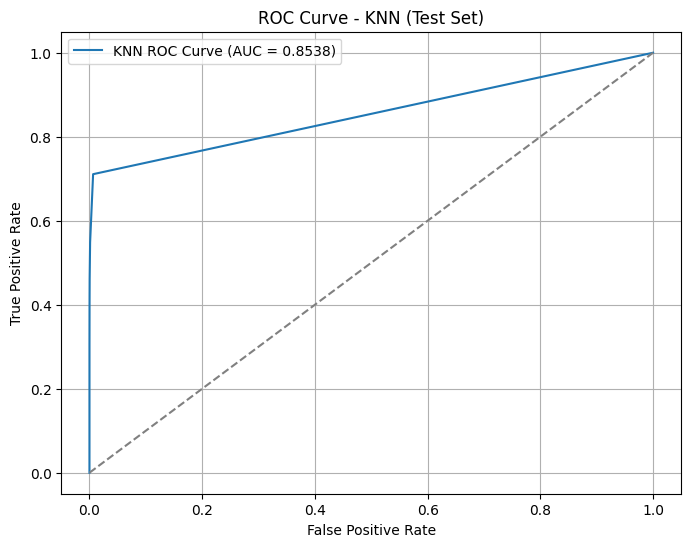

In [5]:
# importing necessary libraries for data loading and EDA
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier  # Import KNN

warnings.filterwarnings('ignore')

# Loading the data
file_path = '/home/ducanh/Credit Card Transactions Fraud Detection/Datasets/combined_data.csv'
df = pd.read_csv(file_path)

# ------------------ Data Preprocessing ------------------
# Convert transaction time and create time-related features
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['trans_date_trans_time_numeric'] = df['trans_date_trans_time'].apply(lambda x: x.timestamp())
df['trans_hour'] = df['trans_date_trans_time'].dt.time.apply(lambda x: str(x)[:2])

# Process date of birth and compute customer age
df['dob'] = pd.to_datetime(df['dob'])
df['cust_age'] = df['dob'].dt.year.apply(lambda x: 2021 - x)
df['cust_age_groups'] = df['cust_age'].apply(lambda x: 'below 10' if x < 10 else (
    '10-20' if x >= 10 and x < 20 else (
    '20-30' if x >= 20 and x < 30 else (
    '30-40' if x >= 30 and x < 40 else (
    '40-50' if x >= 40 and x < 50 else (
    '50-60' if x >= 50 and x < 60 else (
    '60-70' if x >= 60 and x < 70 else (
    '70-80' if x >= 70 and x < 80 else 'Above 80'))))))))

# Map age groups based on average fraudulent transaction amount
age_piv_2 = pd.pivot_table(data=df,
                           index='cust_age_groups',
                           columns='is_fraud',
                           values='amt',
                           aggfunc=np.mean)
age_piv_2.sort_values(by=1, ascending=True, inplace=True)
age_dic = {k: v for (k, v) in zip(age_piv_2.index.values, age_piv_2.reset_index().index.values)}
df['cust_age_groups'] = df['cust_age_groups'].map(age_dic)

# Encode categorical features 'category' and 'job' based on average fraudulent transaction amount
merch_cat = df[df['is_fraud'] == 1].groupby('category')['amt'].mean().sort_values(ascending=True)
merch_cat_dic = {k: v for (k, v) in zip(merch_cat.index.values, merch_cat.reset_index().index.values)}
df['category'] = df['category'].map(merch_cat_dic)

job_txn_piv_2 = pd.pivot_table(data=df,
                               index='job',
                               columns='is_fraud',
                               values='amt',
                               aggfunc=np.mean)
job_cat_dic = {k: v for (k, v) in zip(job_txn_piv_2.index.values, job_txn_piv_2.reset_index().index.values)}
df['job'] = df['job'].map(job_cat_dic)

# Encode identifier variables using factorize
df['merchant_num'] = pd.factorize(df['merchant'])[0]
df['last_num'] = pd.factorize(df['last'])[0]
df['street_num'] = pd.factorize(df['street'])[0]
df['city_num'] = pd.factorize(df['city'])[0]
df['zip_num'] = pd.factorize(df['zip'])[0]
df['state_num'] = pd.factorize(df['state'])[0]
df = pd.get_dummies(data=df, columns=['gender'], drop_first=True, dtype='int')

# Drop unnecessary columns
drop_cols = ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'first', 'last', 'street', 'city', 'state', 
             'lat', 'long', 'dob', 'unix_time', 'merch_lat', 'merch_long', 'city_pop']
df.drop(columns=drop_cols, errors='ignore', inplace=True)

# ------------------ Train-test Split ------------------
train, test = train_test_split(df, test_size=0.33, random_state=42, stratify=df['is_fraud'])
print("Shape of training data:", train.shape)
print("Shape of testing data:", test.shape)

# Drop column 'trans_num' if it exists
train.drop('trans_num', axis=1, inplace=True, errors='ignore')
test.drop('trans_num', axis=1, inplace=True, errors='ignore')

# Separate features and labels
y_train = train['is_fraud']
X_train = train.drop('is_fraud', axis=1)
y_test = test['is_fraud']
X_test = test.drop('is_fraud', axis=1)

print('Shape of training data: ', (X_train.shape, y_train.shape))
print('Shape of testing data: ', (X_test.shape, y_test.shape))

# --- Display features used for training ---
print("\nFeatures used for training (in X_train):")
print(X_train.columns.tolist())

print("\nAll features in DataFrame after preprocessing:")
print(df.columns.tolist())

# ------------------ Scaling ------------------
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

X_train_sc = pd.DataFrame(data=X_train_sc, columns=X_train.columns)
X_test_sc = pd.DataFrame(data=X_test_sc, columns=X_test.columns)

# ------------------ Train KNN Classifier ------------------
knn_model = KNeighborsClassifier(n_neighbors=5)  # Default n_neighbors set to 5
knn_model.fit(X_train_sc, y_train)

# Predict probabilities for training and testing sets
y_pred_train_proba_knn = knn_model.predict_proba(X_train_sc)
y_pred_test_proba_knn = knn_model.predict_proba(X_test_sc)

# Save prediction probabilities into DataFrames
y_train_results_knn = pd.DataFrame(y_pred_train_proba_knn, columns=['pred_not_fraud', 'pred_fraud'])
y_test_results_knn = pd.DataFrame(y_pred_test_proba_knn, columns=['pred_not_fraud', 'pred_fraud'])
y_train_results_knn['y_train_actual'] = y_train.values
y_test_results_knn['y_test_actual'] = y_test.values

# ------------------ KNN does not have a built-in feature importance ------------------
# We can optionally inspect nearest neighbor indices or distances, but it's not directly interpretable like tree-based models.
# For now, we proceed with model evaluation.

# ------------------ Evaluation on Train Set ------------------
numbers = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
cutoff_train_df_knn = pd.DataFrame(columns=['Threshold', 'Accuracy', 'precision_score', 'recall_score', 'F1_score'])

for thresh in numbers:
    # Generate binary predictions based on threshold
    y_pred_bin = y_train_results_knn['pred_fraud'].apply(lambda x: 1 if x > thresh else 0)
    cm = confusion_matrix(y_train_results_knn['y_train_actual'], y_pred_bin)
    TP = cm[1, 1] if cm.shape[0] > 1 and cm.shape[1] > 1 else 0
    FP = cm[0, 1] if cm.shape[1] > 1 else 0
    FN = cm[1, 0] if cm.shape[0] > 1 else 0
    TN = cm[0, 0]
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score_value = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    cutoff_train_df_knn.loc[thresh] = [thresh, accuracy, precision, recall, f1_score_value]

print("\n--- KNN Train Set Evaluation ---")
print(cutoff_train_df_knn)

best_idx_train_knn = cutoff_train_df_knn['F1_score'].idxmax()
best_threshold_train_knn = cutoff_train_df_knn.loc[best_idx_train_knn, 'Threshold']
best_auc_train_knn = roc_auc_score(y_train_results_knn['y_train_actual'], y_train_results_knn['pred_fraud'])
print(f'KNN Train - Best Threshold: {best_threshold_train_knn:.4f}')
print(f'KNN Train - Best ROC_AUC Score: {best_auc_train_knn:.4f}')

# ------------------ Evaluation on Test Set ------------------
cutoff_test_df_knn = pd.DataFrame(columns=['Threshold', 'Accuracy', 'precision_score', 'recall_score', 'F1_score'])

for thresh in numbers:
    y_pred_bin = y_test_results_knn['pred_fraud'].apply(lambda x: 1 if x > thresh else 0)
    cm = confusion_matrix(y_test_results_knn['y_test_actual'], y_pred_bin)
    TP = cm[1, 1] if cm.shape[0] > 1 and cm.shape[1] > 1 else 0
    FP = cm[0, 1] if cm.shape[1] > 1 else 0
    FN = cm[1, 0] if cm.shape[0] > 1 else 0
    TN = cm[0, 0]
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score_value = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    cutoff_test_df_knn.loc[thresh] = [thresh, accuracy, precision, recall, f1_score_value]

print("\n--- KNN Test Set Evaluation ---")
print(cutoff_test_df_knn)

best_idx_test_knn = cutoff_test_df_knn['F1_score'].idxmax()
best_threshold_test_knn = cutoff_test_df_knn.loc[best_idx_test_knn, 'Threshold']
best_accuracy_test_knn = cutoff_test_df_knn.loc[best_idx_test_knn, 'Accuracy']
best_precision_test_knn = cutoff_test_df_knn.loc[best_idx_test_knn, 'precision_score']
best_recall_test_knn = cutoff_test_df_knn.loc[best_idx_test_knn, 'recall_score']
best_f1_score_test_knn = cutoff_test_df_knn.loc[best_idx_test_knn, 'F1_score']
best_auc_test_knn = roc_auc_score(y_test_results_knn['y_test_actual'], y_test_results_knn['pred_fraud'])
print(f'KNN Test - Best Threshold: {best_threshold_test_knn:.4f}')
print(f'KNN Test - Best Accuracy: {best_accuracy_test_knn:.4f}')
print(f'KNN Test - Best Precision: {best_precision_test_knn:.4f}')
print(f'KNN Test - Best Recall: {best_recall_test_knn:.4f}')
print(f'KNN Test - Best F1 Score: {best_f1_score_test_knn:.4f}')
print(f'KNN Test - Best ROC_AUC Score: {best_auc_test_knn:.4f}')

# ------------------ Plot ROC Curve for Test Set ------------------
fpr, tpr, _ = roc_curve(y_test_results_knn['y_test_actual'], y_test_results_knn['pred_fraud'])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'KNN ROC Curve (AUC = {best_auc_test_knn:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN (Test Set)')
plt.legend()
plt.grid(True)
plt.show()

## LightGBM

Shape of training data: (1241103, 18)
Shape of testing data: (611291, 18)
Shape of training data:  ((1241103, 16), (1241103,))
Shape of testing data:  ((611291, 16), (611291,))

Các features được đưa vào học (trong X_train):
['category', 'amt', 'zip', 'job', 'trans_hour', 'is_night', 'trans_date_trans_time_numeric', 'cust_age', 'cust_age_groups', 'merchant_num', 'last_num', 'street_num', 'city_num', 'zip_num', 'state_num', 'gender_M']

Tất cả các features hiện có trong DataFrame sau xử lý:
['category', 'amt', 'zip', 'job', 'trans_num', 'is_fraud', 'trans_hour', 'is_night', 'trans_date_trans_time_numeric', 'cust_age', 'cust_age_groups', 'merchant_num', 'last_num', 'street_num', 'city_num', 'zip_num', 'state_num', 'gender_M']
[LightGBM] [Info] Number of positive: 6466, number of negative: 1234637
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you

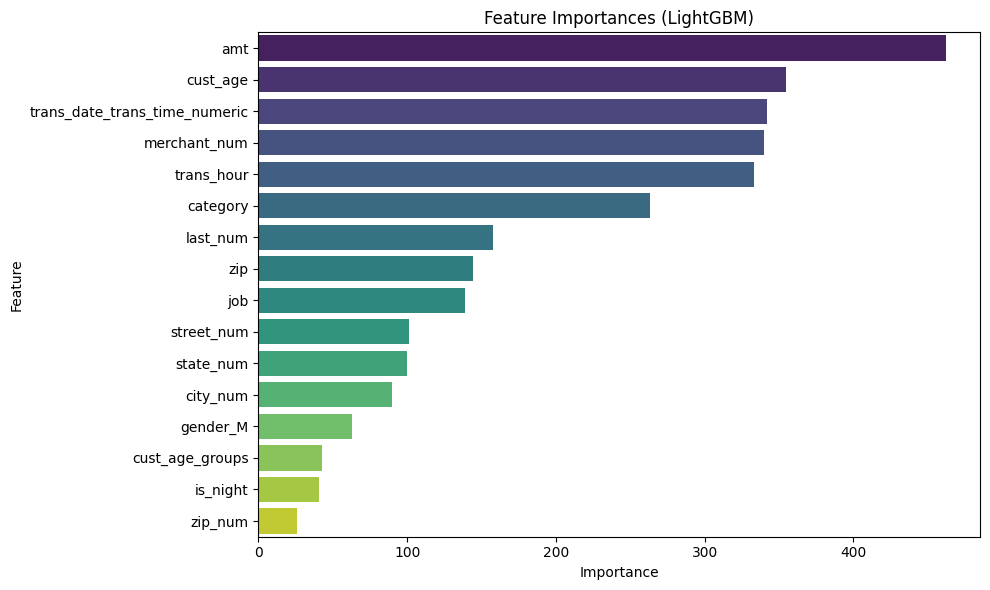


--- LightGBM Train Set Evaluation ---
     Threshold  Accuracy  precision_score  recall_score  F1_score
0.1        0.1  0.997461         0.719740      0.839623  0.775073
0.2        0.2  0.997792         0.767596      0.826477  0.795949
0.3        0.3  0.998165         0.836466      0.805289  0.820582
0.4        0.4  0.998277         0.861850      0.796938  0.828124
0.5        0.5  0.998322         0.874061      0.792144  0.831089
0.6        0.6  0.998348         0.886961      0.782710  0.831581
0.7        0.7  0.998339         0.895758      0.770801  0.828595
0.8        0.8  0.998326         0.902569      0.760749  0.825613
0.9        0.9  0.998169         0.903251      0.726260  0.805144
LightGBM Train - Best Threshold: 0.6000
LightGBM Train - Best ROC_AUC Score: 0.9469

--- LightGBM Test Set Evaluation ---
     Threshold  Accuracy  precision_score  recall_score  F1_score
0.1        0.1  0.996913         0.671602      0.797488  0.729152
0.2        0.2  0.997224         0.712450      

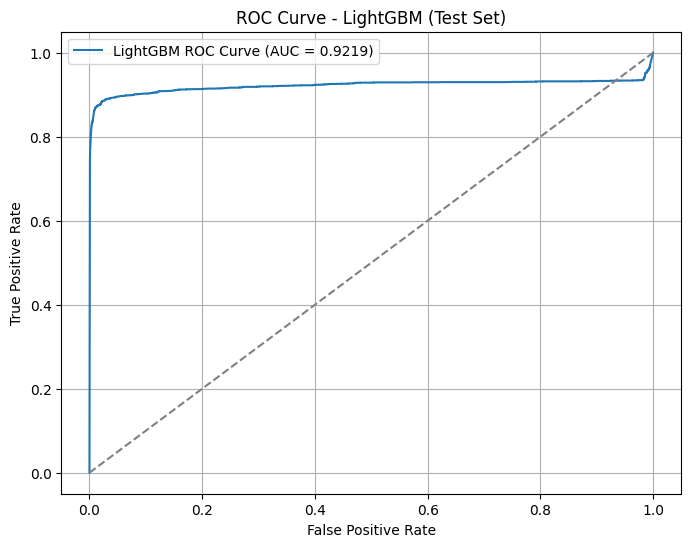

In [6]:
# importing necessary libraries for data loading and EDA
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import lightgbm as lgb

warnings.filterwarnings('ignore')

# Loading the data
file_path = '/home/ducanh/Credit Card Transactions Fraud Detection/Datasets/combined_data.csv'
df = pd.read_csv(file_path)

# ------------------ Data Preprocessing ------------------
# Chuyển đổi thời gian và tạo các feature liên quan
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['trans_date_trans_time_numeric'] = df['trans_date_trans_time'].apply(lambda x: x.timestamp())
# Lấy giờ giao dịch: lấy phần đầu của chuỗi time (dạng hh)
df['trans_hour'] = df['trans_date_trans_time'].dt.time.apply(lambda x: str(x)[:2])

# Xử lý ngày sinh và tính tuổi khách hàng
df['dob'] = pd.to_datetime(df['dob'])
df['cust_age'] = df['dob'].dt.year.apply(lambda x: 2021 - x)
df['cust_age_groups'] = df['cust_age'].apply(lambda x: 'below 10' if x < 10 else (
    '10-20' if x >= 10 and x < 20 else (
    '20-30' if x >= 20 and x < 30 else (
    '30-40' if x >= 30 and x < 40 else (
    '40-50' if x >= 40 and x < 50 else (
    '50-60' if x >= 50 and x < 60 else (
    '60-70' if x >= 60 and x < 70 else (
    '70-80' if x >= 70 and x < 80 else 'Above 80'))))))))

# Mapping nhóm tuổi theo giá trị trung bình của amt trong giao dịch gian lận
age_piv_2 = pd.pivot_table(data=df,
                           index='cust_age_groups',
                           columns='is_fraud',
                           values='amt',
                           aggfunc=np.mean)
age_piv_2.sort_values(by=1, ascending=True, inplace=True)
age_dic = {k: v for (k, v) in zip(age_piv_2.index.values, age_piv_2.reset_index().index.values)}
df['cust_age_groups'] = df['cust_age_groups'].map(age_dic)

# Encode các biến category và job dựa trên giá trị trung bình của amt trong giao dịch gian lận
merch_cat = df[df['is_fraud'] == 1].groupby('category')['amt'].mean().sort_values(ascending=True)
merch_cat_dic = {k: v for (k, v) in zip(merch_cat.index.values, merch_cat.reset_index().index.values)}
df['category'] = df['category'].map(merch_cat_dic)

job_txn_piv_2 = pd.pivot_table(data=df,
                               index='job',
                               columns='is_fraud',
                               values='amt',
                               aggfunc=np.mean)
job_cat_dic = {k: v for (k, v) in zip(job_txn_piv_2.index.values, job_txn_piv_2.reset_index().index.values)}
df['job'] = df['job'].map(job_cat_dic)

# Encode các biến định danh bằng factorize
df['merchant_num'] = pd.factorize(df['merchant'])[0]
df['last_num'] = pd.factorize(df['last'])[0]
df['street_num'] = pd.factorize(df['street'])[0]
df['city_num'] = pd.factorize(df['city'])[0]
df['zip_num'] = pd.factorize(df['zip'])[0]
df['state_num'] = pd.factorize(df['state'])[0]
df = pd.get_dummies(data=df, columns=['gender'], drop_first=True, dtype='int')
# Bỏ các cột không cần thiết
drop_cols = ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'first', 'last', 'street', 'city', 'state', 
             'lat', 'long', 'dob', 'unix_time', 'merch_lat', 'merch_long', 'city_pop']
df.drop(columns=drop_cols, errors='ignore', inplace=True)

# ------------------ Train-test Split ------------------
train, test = train_test_split(df, test_size=0.33, random_state=42, stratify=df['is_fraud'])
print("Shape of training data:", train.shape)
print("Shape of testing data:", test.shape)

# Loại bỏ cột trans_num nếu có (sẽ bị drop nếu không tồn tại)
train.drop('trans_num', axis=1, inplace=True, errors='ignore')
test.drop('trans_num', axis=1, inplace=True, errors='ignore')

# Tách dữ liệu thành features và label
y_train = train['is_fraud']
X_train = train.drop('is_fraud', axis=1)

y_test = test['is_fraud']
X_test = test.drop('is_fraud', axis=1)

print('Shape of training data: ', (X_train.shape, y_train.shape))
print('Shape of testing data: ', (X_test.shape, y_test.shape))

# --- Kiểm tra các features được sử dụng ---
print("\nCác features được đưa vào học (trong X_train):")
print(X_train.columns.tolist())

print("\nTất cả các features hiện có trong DataFrame sau xử lý:")
print(df.columns.tolist())

# ------------------ Scaling ------------------
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

X_train_sc = pd.DataFrame(data=X_train_sc, columns=X_train.columns)
X_test_sc = pd.DataFrame(data=X_test_sc, columns=X_test.columns)

# ------------------ Huấn luyện LightGBM ------------------
lgb_model = lgb.LGBMClassifier(random_state=42, n_estimators=100)
lgb_model.fit(X_train_sc, y_train)

# Dự đoán xác suất cho tập train và test
y_pred_train_proba_lgb = lgb_model.predict_proba(X_train_sc)
y_pred_test_proba_lgb = lgb_model.predict_proba(X_test_sc)

# Lưu kết quả dự đoán vào DataFrame
y_train_results_lgb = pd.DataFrame(y_pred_train_proba_lgb, columns=['pred_not_fraud', 'pred_fraud'])
y_test_results_lgb = pd.DataFrame(y_pred_test_proba_lgb, columns=['pred_not_fraud', 'pred_fraud'])
y_train_results_lgb['y_train_actual'] = y_train.values
y_test_results_lgb['y_test_actual'] = y_test.values

# ------------------ Tính Feature Importance ------------------
importances = lgb_model.feature_importances_
feature_names = X_train_sc.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df['abs_importance'] = feature_importance_df['Importance'].abs()
feature_importance_df.sort_values(by='abs_importance', ascending=False, inplace=True)

print("\nFeature Importances từ mô hình LightGBM:")
print(feature_importance_df[['Feature', 'Importance']])

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importances (LightGBM)')
plt.tight_layout()
plt.show()

# ------------------ Tính các chỉ số hiệu năng cho tập train ------------------
numbers = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
cutoff_train_df_lgb = pd.DataFrame(columns=['Threshold', 'Accuracy', 'precision_score', 'recall_score', 'F1_score'])

for thresh in numbers:
    # Dự đoán nhị phân theo threshold
    y_pred_bin = y_train_results_lgb['pred_fraud'].map(lambda x: 1 if x > thresh else 0)
    cm = confusion_matrix(y_train_results_lgb['y_train_actual'], y_pred_bin)
    TP = cm[1, 1] if cm.shape[0] > 1 and cm.shape[1] > 1 else 0
    FP = cm[0, 1] if cm.shape[1] > 1 else 0
    FN = cm[1, 0] if cm.shape[0] > 1 else 0
    TN = cm[0, 0]
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score_value = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    cutoff_train_df_lgb.loc[thresh] = [thresh, accuracy, precision, recall, f1_score_value]

print("\n--- LightGBM Train Set Evaluation ---")
print(cutoff_train_df_lgb)

best_idx_train_lgb = cutoff_train_df_lgb['F1_score'].idxmax()
best_threshold_train_lgb = cutoff_train_df_lgb.loc[best_idx_train_lgb, 'Threshold']
best_auc_train_lgb = roc_auc_score(y_train_results_lgb['y_train_actual'], y_train_results_lgb['pred_fraud'])
print(f'LightGBM Train - Best Threshold: {best_threshold_train_lgb:.4f}')
print(f'LightGBM Train - Best ROC_AUC Score: {best_auc_train_lgb:.4f}')

# ------------------ Tính các chỉ số hiệu năng cho tập test ------------------
cutoff_test_df_lgb = pd.DataFrame(columns=['Threshold', 'Accuracy', 'precision_score', 'recall_score', 'F1_score'])

for thresh in numbers:
    y_pred_bin = y_test_results_lgb['pred_fraud'].map(lambda x: 1 if x > thresh else 0)
    cm = confusion_matrix(y_test_results_lgb['y_test_actual'], y_pred_bin)
    TP = cm[1, 1] if cm.shape[0] > 1 and cm.shape[1] > 1 else 0
    FP = cm[0, 1] if cm.shape[1] > 1 else 0
    FN = cm[1, 0] if cm.shape[0] > 1 else 0
    TN = cm[0, 0]
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score_value = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    cutoff_test_df_lgb.loc[thresh] = [thresh, accuracy, precision, recall, f1_score_value]

print("\n--- LightGBM Test Set Evaluation ---")
print(cutoff_test_df_lgb)

best_idx_test_lgb = cutoff_test_df_lgb['F1_score'].idxmax()
best_threshold_test_lgb = cutoff_test_df_lgb.loc[best_idx_test_lgb, 'Threshold']
best_accuracy_test_lgb = cutoff_test_df_lgb.loc[best_idx_test_lgb, 'Accuracy']
best_precision_test_lgb = cutoff_test_df_lgb.loc[best_idx_test_lgb, 'precision_score']
best_recall_test_lgb = cutoff_test_df_lgb.loc[best_idx_test_lgb, 'recall_score']
best_f1_score_test_lgb = cutoff_test_df_lgb.loc[best_idx_test_lgb, 'F1_score']
best_auc_test_lgb = roc_auc_score(y_test_results_lgb['y_test_actual'], y_test_results_lgb['pred_fraud'])
print(f'LightGBM Test - Best Threshold: {best_threshold_test_lgb:.4f}')
print(f'LightGBM Test - Best Accuracy: {best_accuracy_test_lgb:.4f}')
print(f'LightGBM Test - Best Precision: {best_precision_test_lgb:.4f}')
print(f'LightGBM Test - Best Recall: {best_recall_test_lgb:.4f}')
print(f'LightGBM Test - Best F1 Score: {best_f1_score_test_lgb:.4f}')
print(f'LightGBM Test - Best ROC_AUC Score: {best_auc_test_lgb:.4f}')

# ------------------ Vẽ ROC Curve cho tập test ------------------
fpr, tpr, _ = roc_curve(y_test_results_lgb['y_test_actual'], y_test_results_lgb['pred_fraud'])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'LightGBM ROC Curve (AUC = {best_auc_test_lgb:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM (Test Set)')
plt.legend()
plt.grid(True)
plt.show()

## Decision Tree

### Random Forest

Shape of training data: (1241103, 18)
Shape of testing data: (611291, 18)
Shape of training data:  ((1241103, 16), (1241103,))
Shape of testing data:  ((611291, 16), (611291,))

Các features được đưa vào học (trong X_train):
['category', 'amt', 'zip', 'job', 'trans_hour', 'is_night', 'trans_date_trans_time_numeric', 'cust_age', 'cust_age_groups', 'merchant_num', 'last_num', 'street_num', 'city_num', 'zip_num', 'state_num', 'gender_M']

Tất cả các features hiện có trong DataFrame sau xử lý:
['category', 'amt', 'zip', 'job', 'trans_num', 'is_fraud', 'trans_hour', 'is_night', 'trans_date_trans_time_numeric', 'cust_age', 'cust_age_groups', 'merchant_num', 'last_num', 'street_num', 'city_num', 'zip_num', 'state_num', 'gender_M']

Feature Importances từ mô hình Random Forest:
                          Feature  Importance
1                             amt    0.353469
0                        category    0.131563
4                      trans_hour    0.079553
9                    merchant_num  

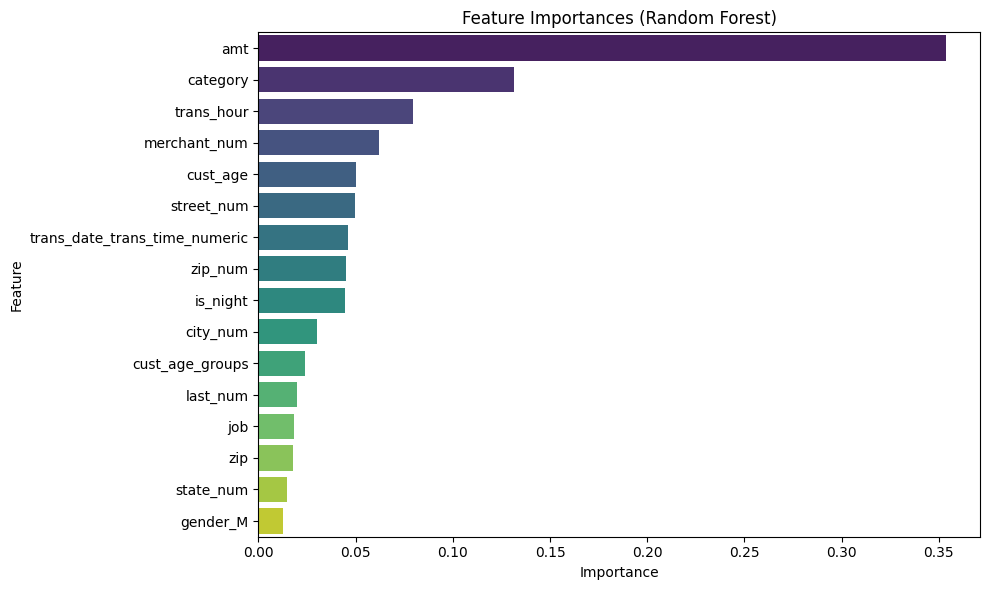


--- Random Forest Train Set Evaluation ---
     Threshold  Accuracy  precision_score  recall_score  F1_score
0.1        0.1  0.999479         0.909040      1.000000  0.952353
0.2        0.2  0.999876         0.976737      1.000000  0.988232
0.3        0.3  0.999978         0.995842      1.000000  0.997917
0.4        0.4  0.999999         0.999845      1.000000  0.999923
0.5        0.5  0.999998         1.000000      0.999691  0.999845
0.6        0.6  0.999867         1.000000      0.974482  0.987076
0.7        0.7  0.999375         1.000000      0.879988  0.936163
0.8        0.8  0.998884         1.000000      0.785803  0.880055
0.9        0.9  0.998218         1.000000      0.657903  0.793657
Random Forest Train - Best Threshold: 0.4000
Random Forest Train - Best ROC_AUC Score: 1.0000

--- Random Forest Test Set Evaluation ---
     Threshold  Accuracy  precision_score  recall_score  F1_score
0.1        0.1  0.997052         0.657410      0.906750  0.762206
0.2        0.2  0.998487   

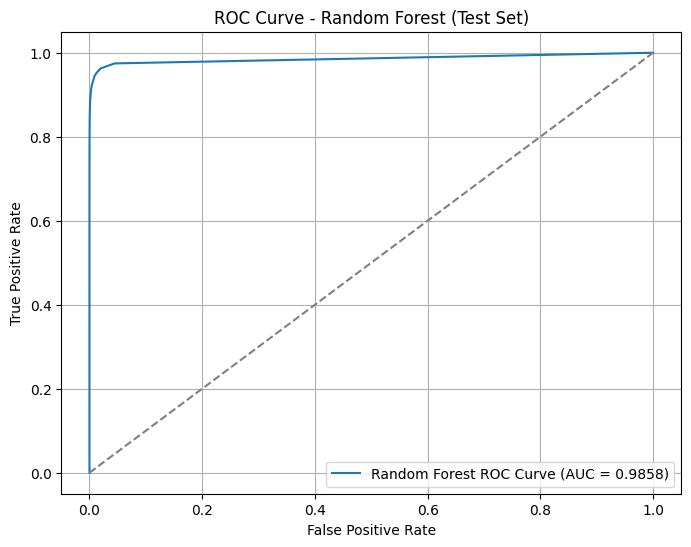

In [7]:
# importing necessary libraries for data loading and EDA
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings('ignore')

# Loading the data
file_path = '/home/ducanh/Credit Card Transactions Fraud Detection/Datasets/combined_data.csv'
df = pd.read_csv(file_path)

# ------------------ Data Preprocessing ------------------
# Chuyển đổi thời gian và tạo các feature liên quan
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['trans_date_trans_time_numeric'] = df['trans_date_trans_time'].apply(lambda x: x.timestamp())
# Lấy giờ giao dịch: lấy phần đầu của chuỗi time (dạng hh)
df['trans_hour'] = df['trans_date_trans_time'].dt.time.apply(lambda x: str(x)[:2])

# Xử lý ngày sinh và tính tuổi khách hàng
df['dob'] = pd.to_datetime(df['dob'])
df['cust_age'] = df['dob'].dt.year.apply(lambda x: 2021 - x)
df['cust_age_groups'] = df['cust_age'].apply(lambda x: 'below 10' if x < 10 else (
    '10-20' if x >= 10 and x < 20 else (
    '20-30' if x >= 20 and x < 30 else (
    '30-40' if x >= 30 and x < 40 else (
    '40-50' if x >= 40 and x < 50 else (
    '50-60' if x >= 50 and x < 60 else (
    '60-70' if x >= 60 and x < 70 else (
    '70-80' if x >= 70 and x < 80 else 'Above 80'))))))))

# Mapping nhóm tuổi theo giá trị trung bình của amt trong giao dịch gian lận
age_piv_2 = pd.pivot_table(data=df,
                           index='cust_age_groups',
                           columns='is_fraud',
                           values='amt',
                           aggfunc=np.mean)
age_piv_2.sort_values(by=1, ascending=True, inplace=True)
age_dic = {k: v for (k, v) in zip(age_piv_2.index.values, age_piv_2.reset_index().index.values)}
df['cust_age_groups'] = df['cust_age_groups'].map(age_dic)

# Encode các biến category và job dựa trên giá trị trung bình của amt trong giao dịch gian lận
merch_cat = df[df['is_fraud'] == 1].groupby('category')['amt'].mean().sort_values(ascending=True)
merch_cat_dic = {k: v for (k, v) in zip(merch_cat.index.values, merch_cat.reset_index().index.values)}
df['category'] = df['category'].map(merch_cat_dic)

job_txn_piv_2 = pd.pivot_table(data=df,
                               index='job',
                               columns='is_fraud',
                               values='amt',
                               aggfunc=np.mean)
job_cat_dic = {k: v for (k, v) in zip(job_txn_piv_2.index.values, job_txn_piv_2.reset_index().index.values)}
df['job'] = df['job'].map(job_cat_dic)

# Encode các biến định danh bằng factorize
df['merchant_num'] = pd.factorize(df['merchant'])[0]
df['last_num'] = pd.factorize(df['last'])[0]
df['street_num'] = pd.factorize(df['street'])[0]
df['city_num'] = pd.factorize(df['city'])[0]
df['zip_num'] = pd.factorize(df['zip'])[0]
df['state_num'] = pd.factorize(df['state'])[0]
df = pd.get_dummies(data=df, columns=['gender'], drop_first=True, dtype='int')
# Bỏ các cột không cần thiết
drop_cols = ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'first', 'last', 'street', 'city', 'state', 
             'lat', 'long', 'dob', 'unix_time', 'merch_lat', 'merch_long', 'city_pop']
df.drop(columns=drop_cols, errors='ignore', inplace=True)

# ------------------ Train-test Split ------------------
train, test = train_test_split(df, test_size=0.33, random_state=42, stratify=df['is_fraud'])
print("Shape of training data:", train.shape)
print("Shape of testing data:", test.shape)

# Loại bỏ cột trans_num nếu có (sẽ bị drop nếu không tồn tại)
train.drop('trans_num', axis=1, inplace=True, errors='ignore')
test.drop('trans_num', axis=1, inplace=True, errors='ignore')

# Tách dữ liệu thành features và label
y_train = train['is_fraud']
X_train = train.drop('is_fraud', axis=1)

y_test = test['is_fraud']
X_test = test.drop('is_fraud', axis=1)

# Loại bỏ cột dạng text không dùng được trong StandardScaler (ví dụ: delta_t_category)
X_train = X_train.drop(columns=['delta_t_category'], errors='ignore')
X_test = X_test.drop(columns=['delta_t_category'], errors='ignore')

print('Shape of training data: ', (X_train.shape, y_train.shape))
print('Shape of testing data: ', (X_test.shape, y_test.shape))

# --- Kiểm tra các features được sử dụng ---
print("\nCác features được đưa vào học (trong X_train):")
print(X_train.columns.tolist())

print("\nTất cả các features hiện có trong DataFrame sau xử lý:")
print(df.columns.tolist())

# ------------------ Scaling ------------------
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

X_train_sc = pd.DataFrame(data=X_train_sc, columns=X_train.columns)
X_test_sc = pd.DataFrame(data=X_test_sc, columns=X_test.columns)

# ------------------ Huấn luyện Random Forest ------------------
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_sc, y_train)

# Dự đoán xác suất cho tập train và test
y_pred_train_proba_rf = rf_model.predict_proba(X_train_sc)
y_pred_test_proba_rf = rf_model.predict_proba(X_test_sc)

# Lưu kết quả dự đoán vào DataFrame
y_train_results_rf = pd.DataFrame(y_pred_train_proba_rf, columns=['pred_not_fraud', 'pred_fraud'])
y_test_results_rf = pd.DataFrame(y_pred_test_proba_rf, columns=['pred_not_fraud', 'pred_fraud'])
y_train_results_rf['y_train_actual'] = y_train.values
y_test_results_rf['y_test_actual'] = y_test.values

# ------------------ Tính Feature Importance ------------------
importances = rf_model.feature_importances_
feature_names = X_train_sc.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df['abs_importance'] = feature_importance_df['Importance'].abs()
feature_importance_df.sort_values(by='abs_importance', ascending=False, inplace=True)

print("\nFeature Importances từ mô hình Random Forest:")
print(feature_importance_df[['Feature', 'Importance']])

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

# ------------------ Tính các chỉ số hiệu năng cho tập train ------------------
numbers = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
cutoff_train_df_rf = pd.DataFrame(columns=['Threshold', 'Accuracy', 'precision_score', 'recall_score', 'F1_score'])

for thresh in numbers:
    # Dự đoán nhị phân theo threshold
    y_pred_bin = y_train_results_rf['pred_fraud'].map(lambda x: 1 if x > thresh else 0)
    cm = confusion_matrix(y_train_results_rf['y_train_actual'], y_pred_bin)
    TP = cm[1, 1] if cm.shape[0] > 1 and cm.shape[1] > 1 else 0
    FP = cm[0, 1] if cm.shape[1] > 1 else 0
    FN = cm[1, 0] if cm.shape[0] > 1 else 0
    TN = cm[0, 0]
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score_value = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    cutoff_train_df_rf.loc[thresh] = [thresh, accuracy, precision, recall, f1_score_value]

print("\n--- Random Forest Train Set Evaluation ---")
print(cutoff_train_df_rf)

best_idx_train_rf = cutoff_train_df_rf['F1_score'].idxmax()
best_threshold_train_rf = cutoff_train_df_rf.loc[best_idx_train_rf, 'Threshold']
best_auc_train_rf = roc_auc_score(y_train_results_rf['y_train_actual'], y_train_results_rf['pred_fraud'])
print(f'Random Forest Train - Best Threshold: {best_threshold_train_rf:.4f}')
print(f'Random Forest Train - Best ROC_AUC Score: {best_auc_train_rf:.4f}')

# ------------------ Tính các chỉ số hiệu năng cho tập test ------------------
cutoff_test_df_rf = pd.DataFrame(columns=['Threshold', 'Accuracy', 'precision_score', 'recall_score', 'F1_score'])

for thresh in numbers:
    y_pred_bin = y_test_results_rf['pred_fraud'].map(lambda x: 1 if x > thresh else 0)
    cm = confusion_matrix(y_test_results_rf['y_test_actual'], y_pred_bin)
    TP = cm[1, 1] if cm.shape[0] > 1 and cm.shape[1] > 1 else 0
    FP = cm[0, 1] if cm.shape[1] > 1 else 0
    FN = cm[1, 0] if cm.shape[0] > 1 else 0
    TN = cm[0, 0]
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score_value = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    cutoff_test_df_rf.loc[thresh] = [thresh, accuracy, precision, recall, f1_score_value]

print("\n--- Random Forest Test Set Evaluation ---")
print(cutoff_test_df_rf)

best_idx_test_rf = cutoff_test_df_rf['F1_score'].idxmax()
best_threshold_test_rf = cutoff_test_df_rf.loc[best_idx_test_rf, 'Threshold']
best_accuracy_test_rf = cutoff_test_df_rf.loc[best_idx_test_rf, 'Accuracy']
best_precision_test_rf = cutoff_test_df_rf.loc[best_idx_test_rf, 'precision_score']
best_recall_test_rf = cutoff_test_df_rf.loc[best_idx_test_rf, 'recall_score']
best_f1_score_test_rf = cutoff_test_df_rf.loc[best_idx_test_rf, 'F1_score']
best_auc_test_rf = roc_auc_score(y_test_results_rf['y_test_actual'], y_test_results_rf['pred_fraud'])
print(f'Random Forest Test - Best Threshold: {best_threshold_test_rf:.4f}')
print(f'Random Forest Test - Best Accuracy: {best_accuracy_test_rf:.4f}')
print(f'Random Forest Test - Best Precision: {best_precision_test_rf:.4f}')
print(f'Random Forest Test - Best Recall: {best_recall_test_rf:.4f}')
print(f'Random Forest Test - Best F1 Score: {best_f1_score_test_rf:.4f}')
print(f'Random Forest Test - Best ROC_AUC Score: {best_auc_test_rf:.4f}')

# ------------------ Vẽ ROC Curve cho tập test ------------------
fpr, tpr, _ = roc_curve(y_test_results_rf['y_test_actual'], y_test_results_rf['pred_fraud'])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest ROC Curve (AUC = {best_auc_test_rf:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (Test Set)')
plt.legend()
plt.grid(True)
plt.show()

## XGBoost

Shape of training data: (1241103, 18)
Shape of testing data: (611291, 18)
Shape of training data:  ((1241103, 16), (1241103,))
Shape of testing data:  ((611291, 16), (611291,))

Các features được đưa vào học (trong X_train):
['category', 'amt', 'zip', 'job', 'trans_hour', 'is_night', 'trans_date_trans_time_numeric', 'cust_age', 'cust_age_groups', 'merchant_num', 'last_num', 'street_num', 'city_num', 'zip_num', 'state_num', 'gender_M']

Tất cả các features hiện có trong DataFrame sau xử lý:
['category', 'amt', 'zip', 'job', 'trans_num', 'is_fraud', 'trans_hour', 'is_night', 'trans_date_trans_time_numeric', 'cust_age', 'cust_age_groups', 'merchant_num', 'last_num', 'street_num', 'city_num', 'zip_num', 'state_num', 'gender_M']


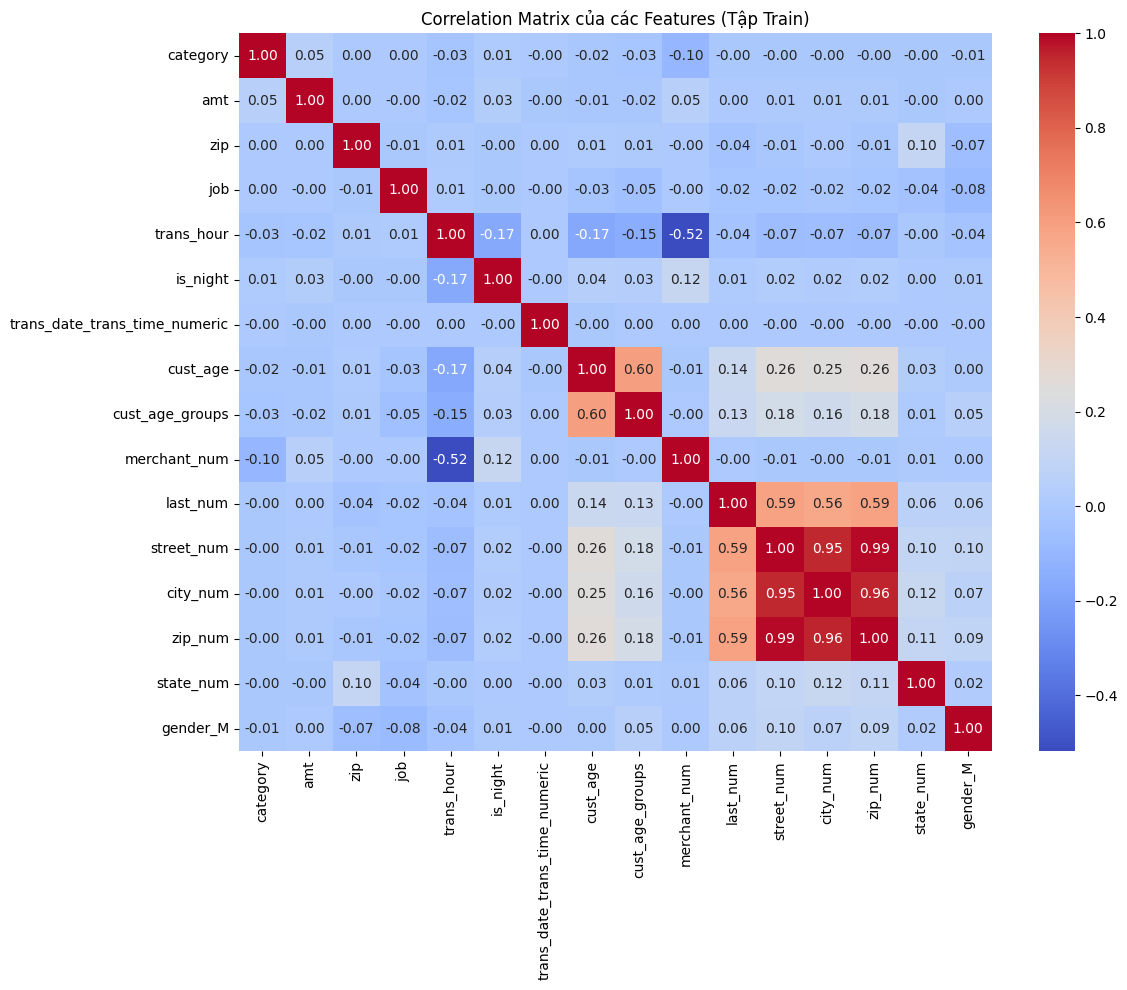

Ma trận tương quan giữa các features:
                               category       amt       zip       job  \
category                       1.000000  0.049271  0.003503  0.000873   
amt                            0.049271  1.000000  0.001791 -0.001785   
zip                            0.003503  0.001791  1.000000 -0.005688   
job                            0.000873 -0.001785 -0.005688  1.000000   
trans_hour                    -0.026264 -0.023710  0.005737  0.012316   
is_night                       0.010891  0.029072 -0.004465 -0.002993   
trans_date_trans_time_numeric -0.000996 -0.002477  0.000831 -0.000402   
cust_age                      -0.016256 -0.010904  0.010656 -0.026312   
cust_age_groups               -0.025497 -0.019127  0.005209 -0.051058   
merchant_num                  -0.103245  0.046915 -0.001062 -0.000535   
last_num                      -0.003014  0.002593 -0.036837 -0.020612   
street_num                    -0.002490  0.008391 -0.010158 -0.021466   
city_num     

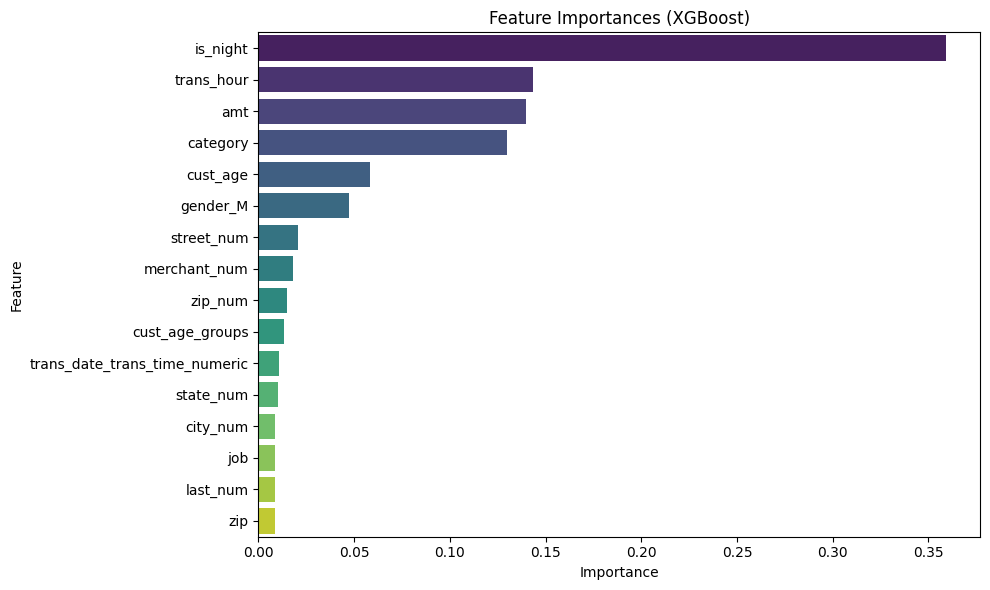


--- XGBoost Train Set Evaluation ---
     Threshold  Accuracy  precision_score  recall_score  F1_score
0.1        0.1  0.998613         0.800939      0.976338  0.879983
0.2        0.2  0.999365         0.922848      0.958243  0.940212
0.3        0.3  0.999479         0.963518      0.935354  0.949227
0.4        0.4  0.999450         0.978175      0.914940  0.945501
0.5        0.5  0.999390         0.986867      0.894835  0.938600
0.6        0.6  0.999301         0.992610      0.872410  0.928636
0.7        0.7  0.999173         0.995988      0.844726  0.914142
0.8        0.8  0.998964         0.998844      0.802041  0.889689
0.9        0.9  0.998618         1.000000      0.734766  0.847107
XGBoost Train - Best Threshold: 0.3000
XGBoost Train - Best ROC_AUC Score: 0.9999

--- XGBoost Test Set Evaluation ---
     Threshold  Accuracy  precision_score  recall_score  F1_score
0.1        0.1  0.998073         0.757110      0.927786  0.833804
0.2        0.2  0.998803         0.875191      0.89

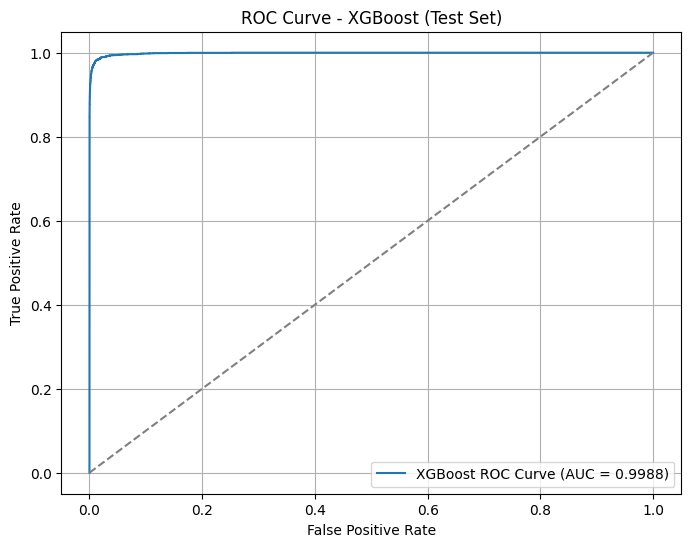

In [8]:
# importing necessary libraries for data loading and EDA
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
import xgboost as xgb

warnings.filterwarnings('ignore')

# Loading the data
file_path = '/home/ducanh/Credit Card Transactions Fraud Detection/Datasets/combined_data.csv'
df = pd.read_csv(file_path)

# ------------------ Data Preprocessing ------------------
# Chuyển đổi thời gian và tạo các feature liên quan
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['trans_date_trans_time_numeric'] = df['trans_date_trans_time'].apply(lambda x: x.timestamp())
# Lấy giờ giao dịch: lấy phần đầu của chuỗi time (dạng hh)
df['trans_hour'] = df['trans_date_trans_time'].dt.time.apply(lambda x: str(x)[:2])

# Xử lý ngày sinh và tính tuổi khách hàng
df['dob'] = pd.to_datetime(df['dob'])
df['cust_age'] = df['dob'].dt.year.apply(lambda x: 2021 - x)
df['cust_age_groups'] = df['cust_age'].apply(lambda x: 'below 10' if x < 10 else (
    '10-20' if x >= 10 and x < 20 else (
    '20-30' if x >= 20 and x < 30 else (
    '30-40' if x >= 30 and x < 40 else (
    '40-50' if x >= 40 and x < 50 else (
    '50-60' if x >= 50 and x < 60 else (
    '60-70' if x >= 60 and x < 70 else (
    '70-80' if x >= 70 and x < 80 else 'Above 80'))))))))

# Mapping nhóm tuổi theo giá trị trung bình của amt trong giao dịch gian lận
age_piv_2 = pd.pivot_table(data=df,
                           index='cust_age_groups',
                           columns='is_fraud',
                           values='amt',
                           aggfunc=np.mean)
age_piv_2.sort_values(by=1, ascending=True, inplace=True)
age_dic = {k: v for (k, v) in zip(age_piv_2.index.values, age_piv_2.reset_index().index.values)}
df['cust_age_groups'] = df['cust_age_groups'].map(age_dic)

# Encode các biến category và job dựa trên giá trị trung bình của amt trong giao dịch gian lận
merch_cat = df[df['is_fraud'] == 1].groupby('category')['amt'].mean().sort_values(ascending=True)
merch_cat_dic = {k: v for (k, v) in zip(merch_cat.index.values, merch_cat.reset_index().index.values)}
df['category'] = df['category'].map(merch_cat_dic)

job_txn_piv_2 = pd.pivot_table(data=df,
                               index='job',
                               columns='is_fraud',
                               values='amt',
                               aggfunc=np.mean)
job_cat_dic = {k: v for (k, v) in zip(job_txn_piv_2.index.values, job_txn_piv_2.reset_index().index.values)}
df['job'] = df['job'].map(job_cat_dic)

# Encode các biến định danh bằng factorize
df['merchant_num'] = pd.factorize(df['merchant'])[0]
df['last_num'] = pd.factorize(df['last'])[0]
df['street_num'] = pd.factorize(df['street'])[0]
df['city_num'] = pd.factorize(df['city'])[0]
df['zip_num'] = pd.factorize(df['zip'])[0]
df['state_num'] = pd.factorize(df['state'])[0]
df = pd.get_dummies(data=df, columns=['gender'], drop_first=True, dtype='int')

# Bỏ các cột không cần thiết
drop_cols = ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'first', 'last', 'street', 'city', 'state', 
             'lat', 'long', 'dob', 'unix_time', 'merch_lat', 'merch_long', 'city_pop']
df.drop(columns=drop_cols, errors='ignore', inplace=True)

# ------------------ Train-test Split ------------------
train, test = train_test_split(df, test_size=0.33, random_state=42, stratify=df['is_fraud'])
print("Shape of training data:", train.shape)
print("Shape of testing data:", test.shape)

# Loại bỏ cột trans_num nếu có (sẽ bị drop nếu không tồn tại)
train.drop('trans_num', axis=1, inplace=True, errors='ignore')
test.drop('trans_num', axis=1, inplace=True, errors='ignore')

# Tách dữ liệu thành features và label
y_train = train['is_fraud']
X_train = train.drop('is_fraud', axis=1)

y_test = test['is_fraud']
X_test = test.drop('is_fraud', axis=1)

# Loại bỏ cột dạng text không dùng được trong StandardScaler (ví dụ: delta_t_category)
X_train = X_train.drop(columns=['delta_t_category'], errors='ignore')
X_test = X_test.drop(columns=['delta_t_category'], errors='ignore')

print('Shape of training data: ', (X_train.shape, y_train.shape))
print('Shape of testing data: ', (X_test.shape, y_test.shape))

# --- Kiểm tra các features được sử dụng ---
print("\nCác features được đưa vào học (trong X_train):")
print(X_train.columns.tolist())

print("\nTất cả các features hiện có trong DataFrame sau xử lý:")
print(df.columns.tolist())

# ------------------ Scaling ------------------
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

X_train_sc = pd.DataFrame(data=X_train_sc, columns=X_train.columns)
X_test_sc = pd.DataFrame(data=X_test_sc, columns=X_test.columns)

# ------------------ Tính độ tương quan giữa các features (chỉ dùng tập train) ------------------
corr_matrix = X_train_sc.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix của các Features (Tập Train)")
plt.tight_layout()
plt.show()

print("Ma trận tương quan giữa các features:")
print(corr_matrix)

# ------------------ Huấn luyện XGBoost ------------------
# Sử dụng XGBClassifier với n_estimators=100, random_state=42
# Đặt use_label_encoder=False và eval_metric='logloss' để tránh warning
xgb_model = xgb.XGBClassifier(random_state=42, n_estimators=100, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_sc, y_train)

# Dự đoán xác suất cho tập train và test
y_pred_train_proba_xgb = xgb_model.predict_proba(X_train_sc)
y_pred_test_proba_xgb = xgb_model.predict_proba(X_test_sc)

# Lưu kết quả dự đoán vào DataFrame
y_train_results_xgb = pd.DataFrame(y_pred_train_proba_xgb, columns=['pred_not_fraud', 'pred_fraud'])
y_test_results_xgb = pd.DataFrame(y_pred_test_proba_xgb, columns=['pred_not_fraud', 'pred_fraud'])
y_train_results_xgb['y_train_actual'] = y_train.values
y_test_results_xgb['y_test_actual'] = y_test.values

# ------------------ Tính Feature Importance ------------------
importances = xgb_model.feature_importances_
feature_names = X_train_sc.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df['abs_importance'] = feature_importance_df['Importance'].abs()
feature_importance_df.sort_values(by='abs_importance', ascending=False, inplace=True)

print("\nFeature Importances từ mô hình XGBoost:")
print(feature_importance_df[['Feature', 'Importance']])

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importances (XGBoost)')
plt.tight_layout()
plt.show()

# ------------------ Tính các chỉ số hiệu năng cho tập train ------------------
numbers = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
cutoff_train_df_xgb = pd.DataFrame(columns=['Threshold', 'Accuracy', 'precision_score', 'recall_score', 'F1_score'])

for thresh in numbers:
    # Dự đoán nhị phân theo threshold
    y_pred_bin = y_train_results_xgb['pred_fraud'].map(lambda x: 1 if x > thresh else 0)
    cm = confusion_matrix(y_train_results_xgb['y_train_actual'], y_pred_bin)
    TP = cm[1, 1] if cm.shape[0] > 1 and cm.shape[1] > 1 else 0
    FP = cm[0, 1] if cm.shape[1] > 1 else 0
    FN = cm[1, 0] if cm.shape[0] > 1 else 0
    TN = cm[0, 0]
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score_value = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    cutoff_train_df_xgb.loc[thresh] = [thresh, accuracy, precision, recall, f1_score_value]

print("\n--- XGBoost Train Set Evaluation ---")
print(cutoff_train_df_xgb)

best_idx_train_xgb = cutoff_train_df_xgb['F1_score'].idxmax()
best_threshold_train_xgb = cutoff_train_df_xgb.loc[best_idx_train_xgb, 'Threshold']
best_auc_train_xgb = roc_auc_score(y_train_results_xgb['y_train_actual'], y_train_results_xgb['pred_fraud'])
print(f'XGBoost Train - Best Threshold: {best_threshold_train_xgb:.4f}')
print(f'XGBoost Train - Best ROC_AUC Score: {best_auc_train_xgb:.4f}')

# ------------------ Tính các chỉ số hiệu năng cho tập test ------------------
cutoff_test_df_xgb = pd.DataFrame(columns=['Threshold', 'Accuracy', 'precision_score', 'recall_score', 'F1_score'])

for thresh in numbers:
    y_pred_bin = y_test_results_xgb['pred_fraud'].map(lambda x: 1 if x > thresh else 0)
    cm = confusion_matrix(y_test_results_xgb['y_test_actual'], y_pred_bin)
    TP = cm[1, 1] if cm.shape[0] > 1 and cm.shape[1] > 1 else 0
    FP = cm[0, 1] if cm.shape[1] > 1 else 0
    FN = cm[1, 0] if cm.shape[0] > 1 else 0
    TN = cm[0, 0]
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score_value = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    cutoff_test_df_xgb.loc[thresh] = [thresh, accuracy, precision, recall, f1_score_value]

print("\n--- XGBoost Test Set Evaluation ---")
print(cutoff_test_df_xgb)

best_idx_test_xgb = cutoff_test_df_xgb['F1_score'].idxmax()
best_threshold_test_xgb = cutoff_test_df_xgb.loc[best_idx_test_xgb, 'Threshold']
best_accuracy_test_xgb = cutoff_test_df_xgb.loc[best_idx_test_xgb, 'Accuracy']
best_precision_test_xgb = cutoff_test_df_xgb.loc[best_idx_test_xgb, 'precision_score']
best_recall_test_xgb = cutoff_test_df_xgb.loc[best_idx_test_xgb, 'recall_score']
best_f1_score_test_xgb = cutoff_test_df_xgb.loc[best_idx_test_xgb, 'F1_score']
best_auc_test_xgb = roc_auc_score(y_test_results_xgb['y_test_actual'], y_test_results_xgb['pred_fraud'])
print(f'XGBoost Test - Best Threshold: {best_threshold_test_xgb:.4f}')
print(f'XGBoost Test - Best Accuracy: {best_accuracy_test_xgb:.4f}')
print(f'XGBoost Test - Best Precision: {best_precision_test_xgb:.4f}')
print(f'XGBoost Test - Best Recall: {best_recall_test_xgb:.4f}')
print(f'XGBoost Test - Best F1 Score: {best_f1_score_test_xgb:.4f}')
print(f'XGBoost Test - Best ROC_AUC Score: {best_auc_test_xgb:.4f}')

# ------------------ Vẽ ROC Curve cho tập test ------------------
fpr, tpr, _ = roc_curve(y_test_results_xgb['y_test_actual'], y_test_results_xgb['pred_fraud'])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost ROC Curve (AUC = {best_auc_test_xgb:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost (Test Set)')
plt.legend()
plt.grid(True)
plt.show()